<a href="https://colab.research.google.com/github/nestorjuarezR/Data_Science/blob/main/Proyecto_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
pip install Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Escalado de Datos
from sklearn.preprocessing import StandardScaler

#Polynomial
from sklearn.preprocessing import PolynomialFeatures

#Modelo Benchmark
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Models
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import VotingRegressor
from mlxtend.regressor import StackingRegressor


#Metricas 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Rede neuronales
import tensorflow as tf
from sklearn.neural_network import MLPRegressor

from sklearn import  metrics
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url = '/content/drive/MyDrive/Data/properati.csv'
data = pd.read_csv(url)

In [3]:
def valores_nulos(dataset):
  print('<------------->')
  print('Porcentaje de Valores nulos\n')
  print(dataset.isnull().sum() / dataset.shape[0] * 100)

https://medium.com/@manilwagle/predicting-house-prices-using-machine-learning-cab0b82cd3f

https://towardsdatascience.com/predicting-house-prices-with-linear-regression-machine-learning-from-scratch-part-ii-47a0238aeac



# Filtrado de Información

Empleo los mismo filtros de información solicitados desde el proyecto 1.

In [4]:
data_ml=data[(data.l2 == 'Capital Federal') & (data.property_type.isin(['Departamento', 'Casa', 'PH']))]
data_ml = data_ml[(data_ml.surface_total >= 15)] 
data_ml = data_ml[(data_ml.surface_total <= 1000)]
data_ml = data_ml[(data_ml.price <= 4000000 )]
data_ml = data_ml[['l3','property_type','rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']]

In [5]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.068311
surface_total      0.000000
surface_covered    0.627633
price              0.000000
dtype: float64


In [6]:
#¿Presencia de valores invertidos?
datos_invertidos= data_ml.loc[data_ml.surface_total < data_ml.surface_covered]
print('Existen', len(datos_invertidos),'datos invertidos')

Existen 751 datos invertidos


Ya que no cuento con información que respalde que los usuarios realizaron un mal llenado de los datos en la plataforma, introduciendo los datos acerca de superficie cubierta en el campo correspondiente a superficie total. Por lo que en la data, se encuentran valores de superficie cubierta mayores a superficie total.
Ya que estos datos no representan un gran porcentaje de datos, decidido eliminarlos.


In [7]:
#Limpieza de valores invertidos
data_ml = data_ml[(data_ml.surface_total >= data_ml.surface_covered)]

In [8]:
#Comprobación 
datos_invertidos_2= data_ml.loc[data_ml.surface_total < data_ml.surface_covered]
print('Existen', len(datos_invertidos_2),'datos invertidos')

Existen 0 datos invertidos


In [9]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.022132
surface_total      0.000000
surface_covered    0.000000
price              0.000000
dtype: float64


Al eliminar la información correspondiente a valores invertidos, la presencia de valores nulos disminuye


In [10]:
#Eliminar informacion duplicada
data_ml.drop_duplicates(inplace=True)

In [11]:
#Copia
data_py2 = data_ml.copy()

#EDA

## Imputación de Valores faltantes

Para la imputación de valores faltantes, decido emplear la media correspondientes a los baños en función del tipo de propiedad.
Por lo que empleo mi dataset copia para obtener la media y así poder imputar en mis data de trabajo.


In [12]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

l3                 0.00000
property_type      0.00000
rooms              0.00000
bathrooms          1.47145
surface_total      0.00000
surface_covered    0.00000
price              0.00000
dtype: float64


In [13]:
#Elimino valores nulos en dataset copia
data_py2.dropna(inplace=True)

In [14]:
#Agrupación segun el tipo de propiedad
mean_bt = data_py2.groupby('property_type')['bathrooms'].mean().round(0)

In [15]:
mean_bt = dict(round(mean_bt))
mean_bt

{'Casa': 2.0, 'Departamento': 2.0, 'PH': 1.0}

In [16]:
#Imputar valores
data_ml.bathrooms = data_ml.bathrooms.fillna(data_ml.property_type.map(mean_bt))

In [17]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

l3                 0.0
property_type      0.0
rooms              0.0
bathrooms          0.0
surface_total      0.0
surface_covered    0.0
price              0.0
dtype: float64


# Análisis Data

In [18]:
data_departamentos = data_ml[data_ml['property_type'] == 'Departamento']

In [19]:
z = data_departamentos.l3.value_counts().head(10)
print('Regiones con mas registros de Departamentos')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Departamentos
--> Palermo
--> Belgrano
--> Recoleta
--> Caballito
--> Almagro
--> Villa Crespo
--> Barrio Norte
--> Villa Urquiza
--> Flores
--> Balvanera


In [20]:
j = data_departamentos.price.value_counts().head(10)
print('Precios mas frecuentes en Departamentos')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Departamentos
--> $120000.0
--> $125000.0
--> $115000.0
--> $135000.0
--> $110000.0
--> $145000.0
--> $165000.0
--> $130000.0
--> $150000.0
--> $105000.0


In [21]:
data_casa = data_ml[data_ml['property_type'] == 'Casa']

In [22]:
z = data_casa.l3.value_counts().head(10)
print('Regiones con mas registros de Casas')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Casas
--> Villa Devoto
--> Flores
--> Mataderos
--> Caballito
--> Villa Lugano
--> Belgrano
--> Villa del Parque
--> Parque Chacabuco
--> Villa Urquiza
--> Floresta


In [23]:
j = data_casa.price.value_counts().head(10)
print('Precios mas frecuentes en Casa')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Casa
--> $350000.0
--> $250000.0
--> $320000.0
--> $260000.0
--> $280000.0
--> $450000.0
--> $220000.0
--> $330000.0
--> $420000.0
--> $180000.0


In [24]:
data_ph = data_ml[data_ml['property_type'] == 'PH']

In [25]:
z = data_ph.l3.value_counts().head(10)
print('Regiones con mas registros de Penthouse')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Penthouse
--> Caballito
--> Palermo
--> Villa Urquiza
--> Villa Devoto
--> Villa Crespo
--> Almagro
--> Flores
--> Villa del Parque
--> Floresta
--> Saavedra


In [26]:
j = data_ph.price.value_counts().head(10)
print('Precios mas frecuentes en Penthouse')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Penthouse
--> $120000.0
--> $150000.0
--> $125000.0
--> $110000.0
--> $175000.0
--> $130000.0
--> $220000.0
--> $155000.0
--> $145000.0
--> $250000.0


#Modelo Benchmark

In [27]:
#Defino la formula de mi regresion para predecir el precio
reg = smf.ols('price ~ rooms + bathrooms + surface_total + surface_covered', data= data_ml)

In [28]:
#Entreno el modelo
res = reg.fit()

In [29]:
#Informe
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 1.802e+04
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:54:13   Log-Likelihood:            -6.4696e+05
No. Observations:               47776   AIC:                         1.294e+06
Df Residuals:                   47771   BIC:                         1.294e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.023e+04   2290.042     

Dado el informe del modelo, las métricas globales para la regresión lineal aplicada, obtuvo un R2 de 0.6.
Esta métrica es más baja que la obtenida en el proyecto 2. 
Ya que en el proyecto 2 en mi modelo final seleccionado `Ridge` obtuve un valor de R2 de 0.77.
Por lo que estos dos valores de mi modelo Benchmark y el modelo del proyecto 2, serán las referencias a superar



# Aumento de Correlación

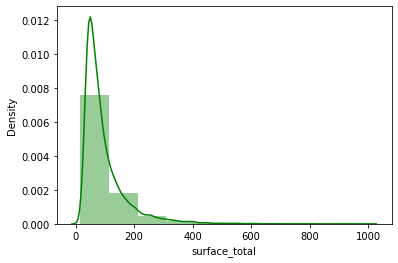

In [30]:
sns.distplot(data_ml.surface_total,
             kde=True,
             color='green',
             bins=10)

Ya que los datos de superficie total , presentan asimetría. Además de presentar varios valores atípicos, y estos afectan directamente al rendimiento del modelo.


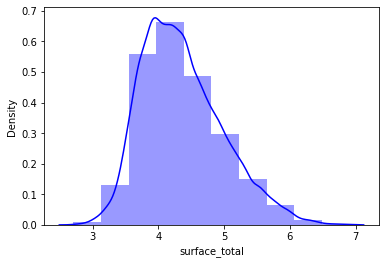

In [31]:
sns.distplot(np.log(data_ml.surface_total), 
             kde=True, 
             color='blue',
             bins=10)

Aplico logaritmo a los datos con el fin de modificar la simetría y como consecuencia los outlier reduzcan.

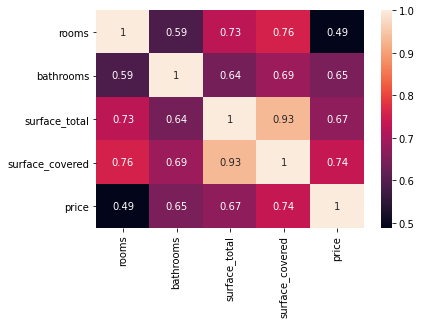

In [32]:
sns.heatmap(data_ml.corr(), annot=True)

Correlación de variables.
En donde rooms es la variable que presenta menor relación, por lo que es de considerarse descartarla.

In [33]:
columnas = ['rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']

for i in columnas:
  data_ml[i]= data_ml[i].map(np.log)

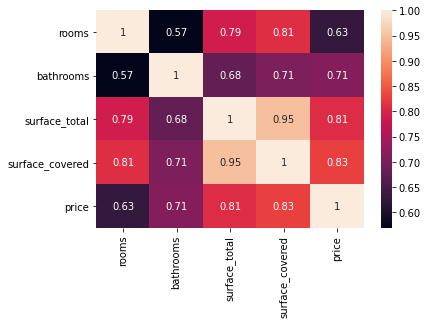

In [34]:
sns.heatmap(data_ml.corr(), annot=True)

Al aplicar logaritmo a las variables, su correlación aumenta. Siendo Room la que se ve más favorecida.

https://github.com/traintestbritt/predicting_house_prices/blob/master/notebook-house_price_predictions-brittany_allen.ipynb

#Divison Datos X e Y

In [35]:
#Separo datos en X e Y
X = data_ml[['rooms', 'bathrooms', 'surface_total', 'surface_covered']]
Y = data_ml[['price']]

In [36]:
X.shape, Y.shape

((47776, 4), (47776, 1))

# Polynomial Features

In [37]:
poly = PolynomialFeatures(degree=4)

In [38]:
features_poly = poly.fit_transform(X)

In [39]:
poly_df = pd.DataFrame(features_poly, columns=poly.get_feature_names())

In [40]:
poly_df.head(2)

,1,x0,x1,x2,x3,x0^2,x0 x1,x0 x2,x0 x3,x1^2,x1 x2,x1 x3,x2^2,x2 x3,x3^2,x0^3,x0^2 x1,x0^2 x2,x0^2 x3,x0 x1^2,x0 x1 x2,x0 x1 x3,x0 x2^2,x0 x2 x3,x0 x3^2,x1^3,x1^2 x2,x1^2 x3,x1 x2^2,x1 x2 x3,x1 x3^2,x2^3,x2^2 x3,x2 x3^2,x3^3,x0^4,x0^3 x1,x0^3 x2,x0^3 x3,x0^2 x1^2,x0^2 x1 x2,x0^2 x1 x3,x0^2 x2^2,x0^2 x2 x3,x0^2 x3^2,x0 x1^3,x0 x1^2 x2,x0 x1^2 x3,x0 x1 x2^2,x0 x1 x2 x3,x0 x1 x3^2,x0 x2^3,x0 x2^2 x3,x0 x2 x3^2,x0 x3^3,x1^4,x1^3 x2,x1^3 x3,x1^2 x2^2,x1^2 x2 x3,x1^2 x3^2,x1 x2^3,x1 x2^2 x3,x1 x2 x3^2,x1 x3^3,x2^4,x2^3 x3,x2^2 x3^2,x2 x3^3,x3^4
0,1.0,1.945910,0.693147,4.941642,4.941642,3.786566,1.348802,9.615992,9.615992,0.480453,3.425286,3.425286,24.419830,24.419830,24.419830,7.368318,2.624648,18.711857,18.711857,0.934918,6.665298,6.665298,47.518795,47.518795,47.518795,0.333025,2.374227,2.374227,16.926536,16.926536,16.926536,120.674067,120.674067,120.674067,120.674067,14.338084,5.107329,36.411592,36.411592,1.819267,12.970071,12.970071,92.467305,92.467305,92.467305,0.648036,4.620032,4.620032,32.937519,32.937519,32.937519,234.820892,234.820892,234.820892,234.820892,0.230835,1.645689,1.645689,11.732581,11.732581,11.732581,83.644889,83.644889,83.644889,83.644889,596.328089,596.328089,596.328089,596.328089,596.328089
1,1.0,0.693147,0.693147,4.248495,4.060443,0.480453,0.480453,2.944832,2.814485,0.480453,2.944832,2.814485,18.049712,17.250773,16.487197,0.333025,0.333025,2.041202,1.950852,0.333025,2.041202,1.950852,12.511107,11.957325,11.428054,0.333025,2.041202,1.950852,12.511107,11.957325,11.428054,76.684115,73.289826,70.045780,66.945326,0.230835,0.230835,1.414854,1.352228,0.230835,1.414854,1.352228,8.672038,8.288186,7.921324,0.230835,1.414854,1.352228,8.672038,8.288186,7.921324,53.153378,50.800636,48.552035,46.402964,0.230835,1.414854,1.352228,8.672038,8.288186,7.921324,53.153378,50.800636,48.552035,46.402964,325.792097,311.371478,297.589163,284.416897,271.827679


In [41]:
poly_df.shape

(47776, 70)

# Escalado de Datos

In [42]:
#Defino el modelo
std = StandardScaler()

In [43]:
#Entreno modelo
std.fit(poly_df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [44]:
#Transformo datos
data_escalada = std.transform(poly_df)

In [45]:
#Conversion a DataFramde
data_escalada = pd.DataFrame(data_escalada)

#Enconding

In [46]:
#Selecciono datos de barrios
l3 = data_ml['l3']

In [47]:
l3_get = pd.get_dummies(l3, prefix=('x'))

In [48]:
#Reseteo Index
data_escalada.reset_index(drop=True, inplace=True)
l3_get.reset_index(drop=True, inplace=True)

In [49]:
poly_df.shape, l3_get.shape

((47776, 70), (47776, 57))

In [50]:
#Union de DataFrames
data_eda = pd.merge(poly_df, l3_get, how='left', left_index=True, right_index=True)

#Modelos

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data_eda, Y,
                                                    test_size=0.25,
                                                    random_state=40)

In [52]:
def evaluar_modelo(modelo,X_train,X_test,y_train,y_test):
    modelo.fit(X_train,y_train)
    print ("* R2 del modelo  en train:", modelo.score(X_train,y_train) )
    print('RMSE en train:',np.sqrt(mean_squared_error(y_train, modelo.predict(X_train))))
    print ("* R2 del modelo en test:", modelo.score(X_test,y_test) )
    print('RMSE en test:',np.sqrt(mean_squared_error(y_test, modelo.predict(X_test))))

In [53]:
def graficos_prediccion(modelo):
  y_pred = modelo.predict(X_test)
  sns.distplot(y_test, kde=False, color='red', bins=50, label='Real price')
  sns.distplot(y_pred, kde=False, color='blue', bins=50, label='Predict price')
  
  plt.xlabel('Sale Price', fontsize=19, labelpad=11)
  plt.xticks(fontsize=14)
  plt.ylabel('Count', fontsize=19, labelpad=11)
  plt.yticks(fontsize=14)
  plt.legend(loc='upper right');

In [54]:
def graficos_error(model):

  #Grafico de error
  y_train_pred_1 = model.predict(X_train)
  y_test_pred_1 = model.predict(X_test)
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_1))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_1))
  plt.figure(figsize = (10,6))
  plt.subplot(1,2,1)
  sns.distplot(y_train - y_train_pred_1, bins = 20, label = 'train')
  sns.distplot(y_test - y_test_pred_1, bins = 20, label = 'test')
  plt.xlabel('errores')
  plt.legend()
  
  #Comparativa predicciones
  plt.subplot(1,2,2)
  sns.distplot(y_test, kde=False, color='red', bins=50, label='Real price')
  sns.distplot(y_test_pred_1, kde=False, color='blue', bins=50, label='Predict price')
  plt.xlabel('Sale Price')
  plt.xticks(fontsize=14)
  plt.ylabel('Count')
  plt.legend(loc='upper right')

In [55]:
def get_random_sample(model, numero_muestra):
  
  #Tomo una muestra de mis datos en Test
  idxs = np.random.randint(X_test.shape[0], size=numero_muestra)

  muestra = X_test.iloc[idxs]
  prediccion = model.predict(muestra)

  valor_data = []
  for i in idxs:
    valor_real = y_test.price.iloc[i]
    valor_data.append(valor_real)

  valor_data = pd.DataFrame((valor_data), columns = ['valor_real'])
  prediccion = pd.DataFrame((prediccion), columns = ['valor_predicho'])
  comparacion = pd.merge(valor_data, prediccion, right_index=True, left_index=True)

  #Grafico
  r = comparacion['valor_real']
  p = comparacion['valor_predicho']
  plt.figure(figsize=(15,4))
  plt.plot(r,'o-',label='Valores reales')
  plt.plot(p,'o-',label='Valores predichos')
  plt.legend()
  plt.title('Comparacion de valores de propiedad')
  plt.xlabel('Muestra')
  plt.ylabel('Precio')

In [56]:
def graficos(model,X_test,y_test):
    y_pred = model.predict(X_test)
    
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    sns.distplot(y_pred, label='Predicciones')
    sns.distplot(y_test, label='Valor real')
    plt.legend()

    plt.subplot(1,2,2)
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

In [ ]:
break

##LinearRegression

In [57]:
linear = LinearRegression()

In [58]:
evaluar_modelo(linear, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.865265439965957
RMSE en train: 0.2528462640244136
* R2 del modelo en test: 0.864774818987119
RMSE en test: 0.2513941367050876


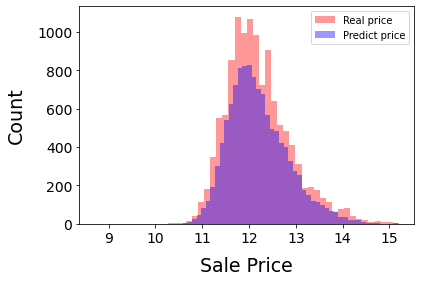

In [59]:
graficos_prediccion(linear)

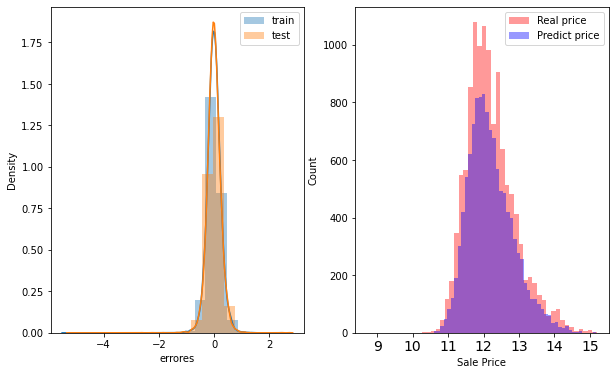

In [60]:
graficos_error(linear)

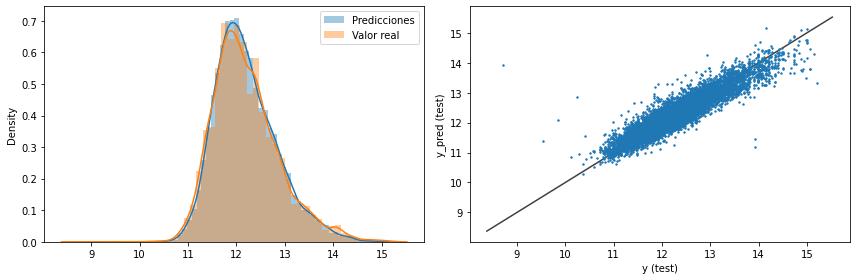

In [67]:
graficos(linear, X_test, y_test)

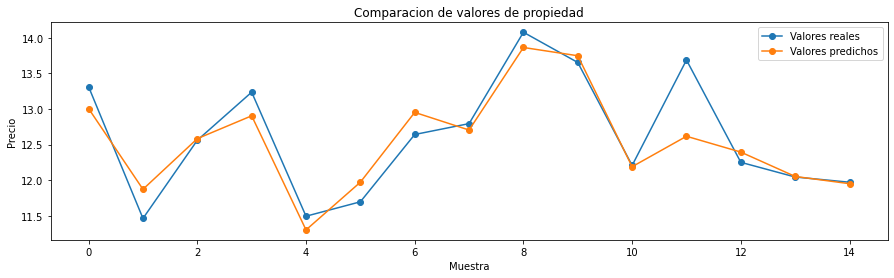

In [61]:
get_random_sample(linear, 15)

##RidgeCV

In [62]:
ridge = RidgeCV()

In [63]:
evaluar_modelo(ridge, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.8649275629785256
RMSE en train: 0.2531630997409384
* R2 del modelo en test: 0.8641445830102552
RMSE en test: 0.2519792845742372


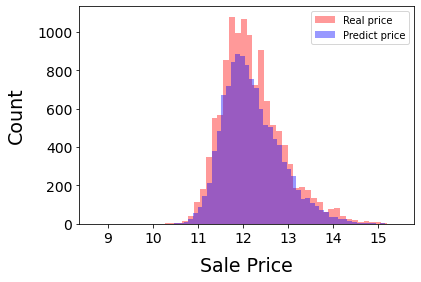

In [64]:
graficos_prediccion(ridge)

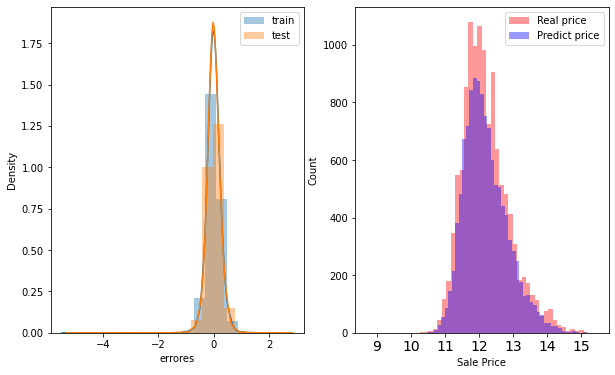

In [65]:
graficos_error(ridge)

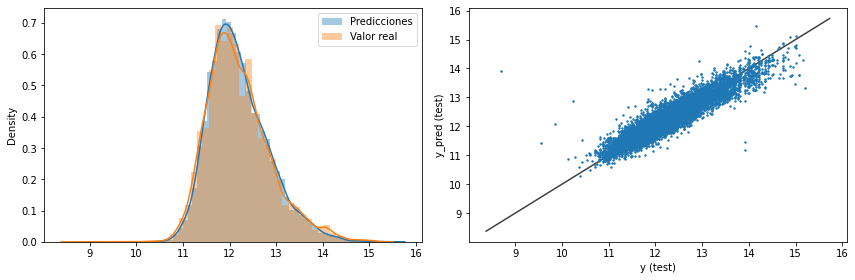

In [66]:
graficos(ridge, X_test, y_test)

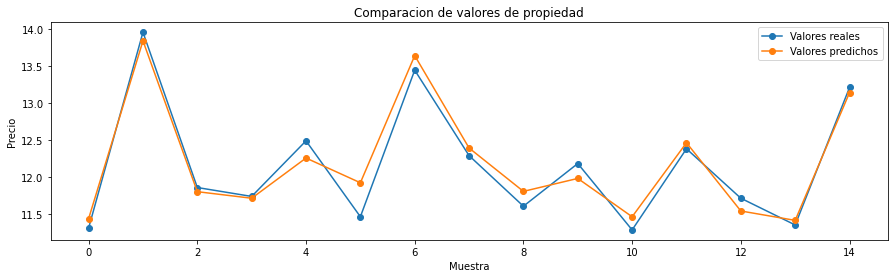

In [68]:
get_random_sample(ridge, 15)

##LassoCV

In [69]:
lasso = LassoCV()

In [70]:
evaluar_modelo(lasso, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.7418291186136658
RMSE en train: 0.35000211237156925
* R2 del modelo en test: 0.7434273243303103
RMSE en test: 0.3462833101042563


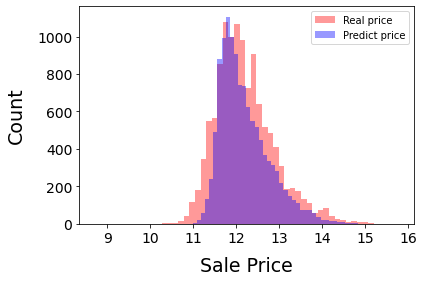

In [71]:
graficos_prediccion(lasso)

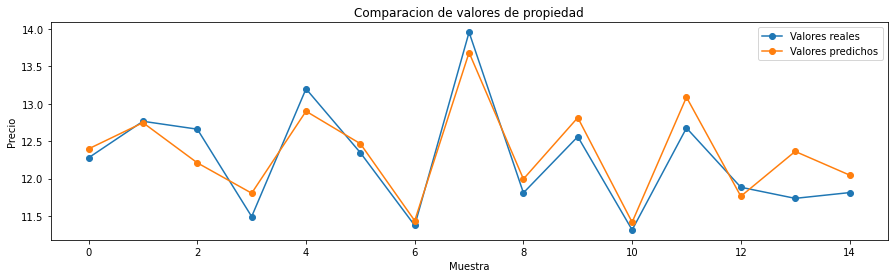

In [72]:
get_random_sample(lasso, 15)

##GradientBoostingRegressor

In [73]:
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [74]:
evaluar_modelo(clf, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9078159811832147
RMSE en train: 0.20914373302399217
* R2 del modelo en test: 0.8725594060125346
RMSE en test: 0.24405080928375106


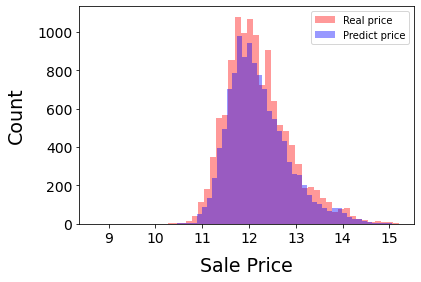

In [75]:
graficos_prediccion(clf)

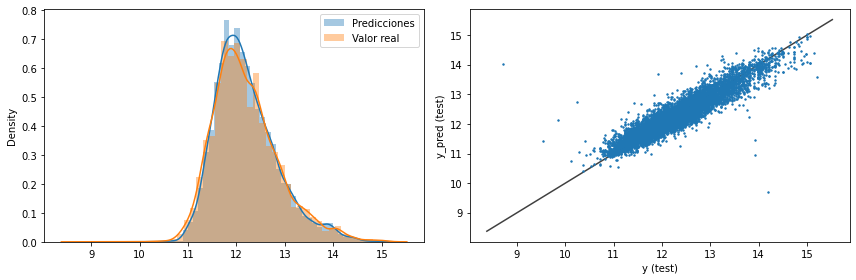

In [76]:
graficos(clf, X_test, y_test)

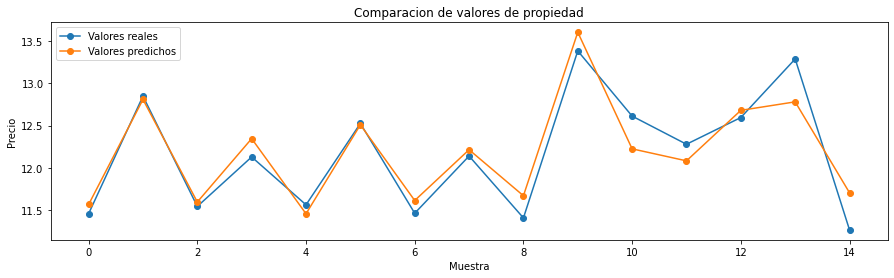

In [77]:
get_random_sample(clf, 15)

##SVR

In [78]:
super_regresor = SVR()

In [ ]:
evaluar_modelo(super_regresor, X_train, X_test, y_train, y_test)

In [ ]:
graficos_prediccion(super_regresor)

In [ ]:
get_random_sample(super_regresor, 15)

##ExtraTreesRegressor

In [ ]:
tree_reg = ExtraTreesRegressor(n_estimators=100, random_state=40)

In [ ]:
evaluar_modelo(tree_reg, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9796121774259672
RMSE en train: 0.00791963658146841
* R2 del modelo en test: 0.8574486530151766
RMSE en test: 0.0207922685657196


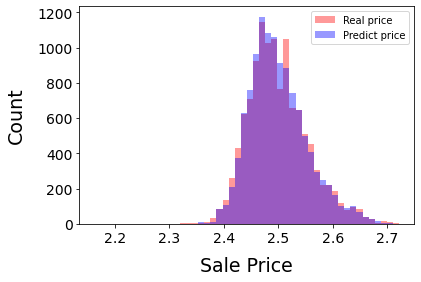

In [ ]:
graficos_prediccion(tree_reg)

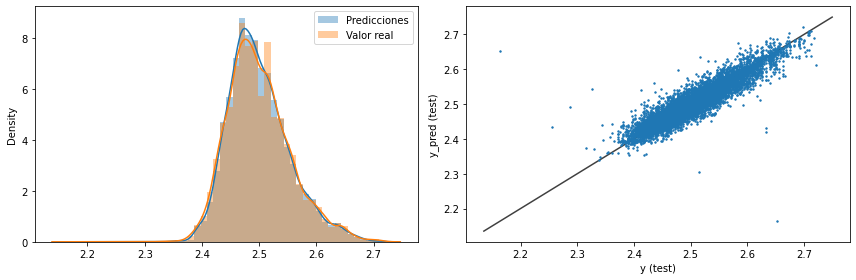

In [ ]:
graficos(tree_reg, X_test, y_test)

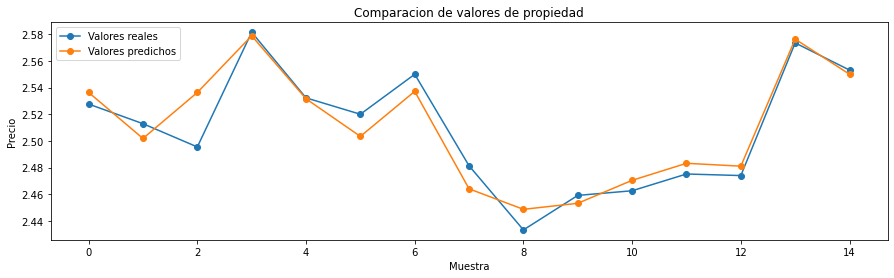

In [ ]:
get_random_sample(tree_reg, 15)

##BayesianRidge

In [ ]:
bay_reg = linear_model.BayesianRidge()

In [ ]:
evaluar_modelo(bay_reg, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.8635358292920579
RMSE en train: 0.020489395730462642
* R2 del modelo en test: 0.8632429632045875
RMSE en test: 0.020365311369980165


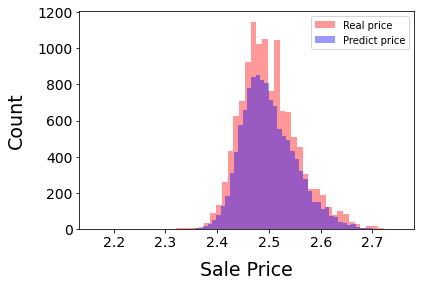

In [ ]:
graficos_prediccion(bay_reg)

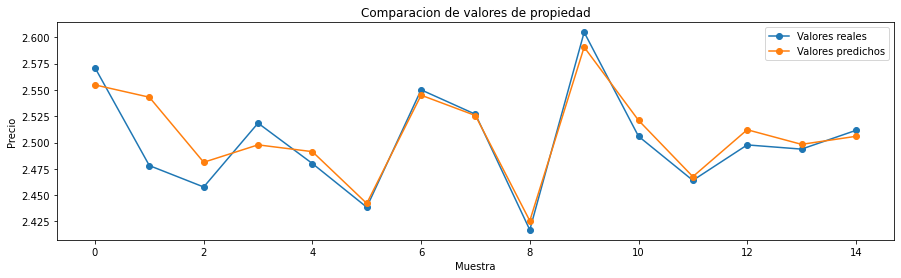

In [ ]:
get_random_sample(bay_reg, 15)

##RandomForestRegressor

In [ ]:
regg = RandomForestRegressor(n_estimators=150)

In [ ]:
evaluar_modelo(regg, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9667227405684045
RMSE en train: 0.010117975105873143
* R2 del modelo en test: 0.8692861525284117
RMSE en test: 0.019910263719022468


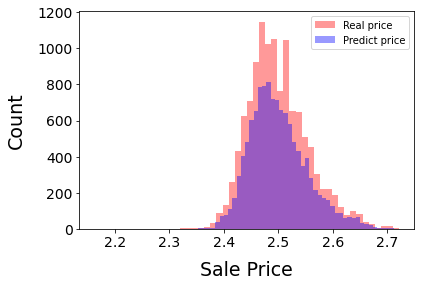

In [ ]:
graficos_prediccion(regg)

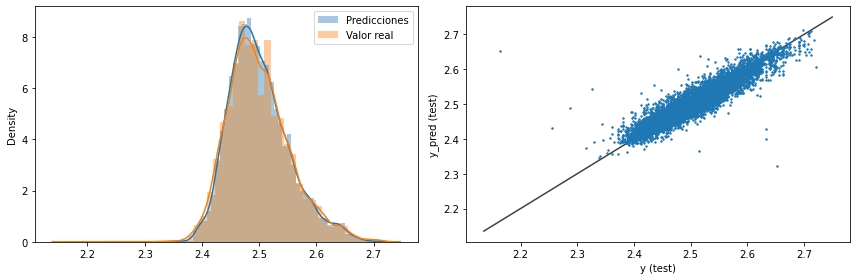

In [ ]:
graficos(regg, X_test, y_test)

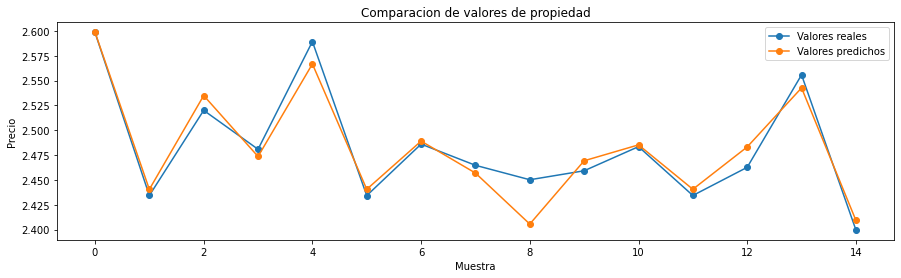

In [ ]:
get_random_sample(regg, 15)

##XGBRegressor

In [ ]:
xg_reg = XGBRegressor()

In [ ]:
evaluar_modelo(xg_reg, X_train, X_test, y_train, y_test)

[19:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
* R2 del modelo  en train: 0.8503375554556253
RMSE en train: 0.02145735802161717
* R2 del modelo en test: 0.8453375117233194
RMSE en test: 0.021657519293887154


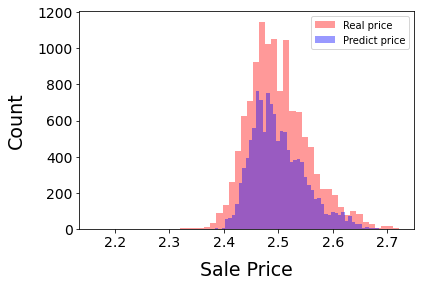

In [ ]:
graficos_prediccion(xg_reg)

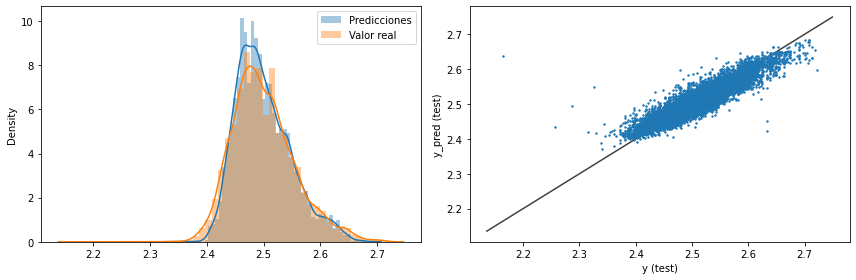

In [ ]:
graficos(xg_reg, X_test, y_test)

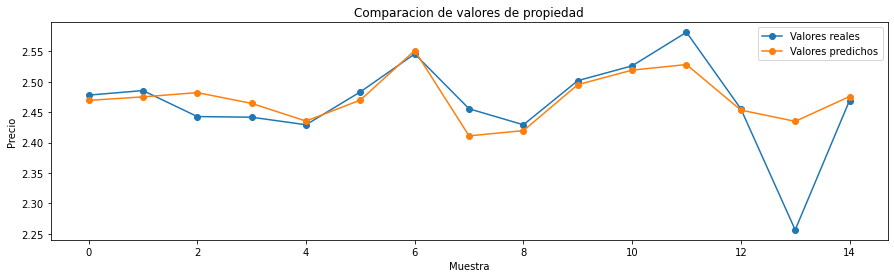

In [ ]:
get_random_sample(xg_reg, 15)

##ElasticNetCV

In [ ]:
elas = ElasticNetCV(cv=5, max_iter=1e7)

In [ ]:
evaluar_modelo(elas, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.7378455471719301
RMSE en train: 0.028398699331984724
* R2 del modelo en test: 0.7398962051630347
RMSE en test: 0.028085978412017345


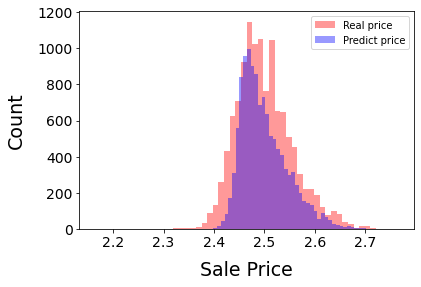

In [ ]:
graficos_prediccion(elas)

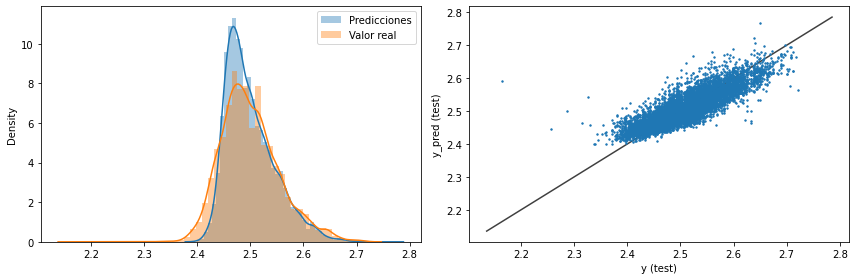

In [ ]:
graficos(elas, X_test, y_test)

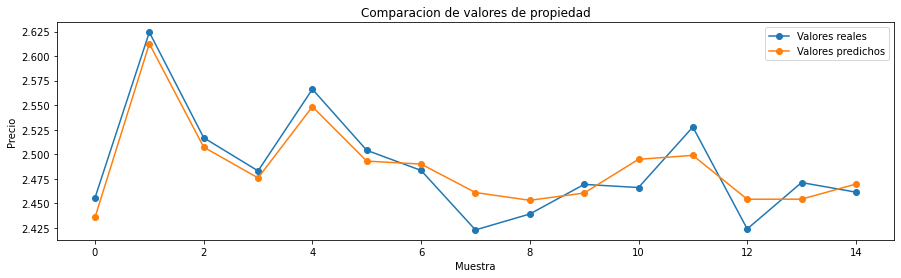

In [ ]:
get_random_sample(elas, 15)

##Voting

En este modelo, empleo los modelos anteriores que obtuvieron los score más alto.
Definiendo el nombre del modelo y como está definido para realizar el ensamble en un único modelo.


In [ ]:
vote_mod = VotingRegressor([('RidgeCV', ridge),
                            ('GradientBoostingRegressor', clf),
                            ('ExtraTreesRegressor', tree_reg), 
                            ('BayesianRidge', bay_reg)])

In [ ]:
evaluar_modelo(vote_mod, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9248053377350209
RMSE en train: 0.015209443952309614
* R2 del modelo en test: 0.8791003595687675
RMSE en test: 0.019148233645378553


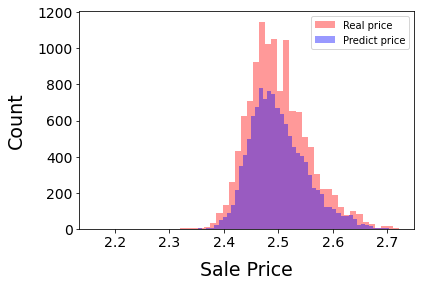

In [ ]:
graficos_prediccion(vote_mod)

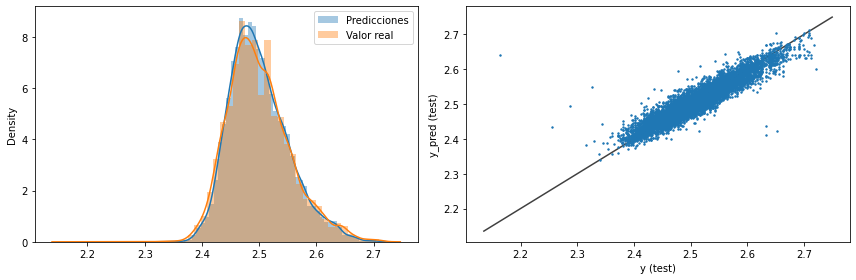

In [ ]:
graficos(vote_mod, X_test, y_test)

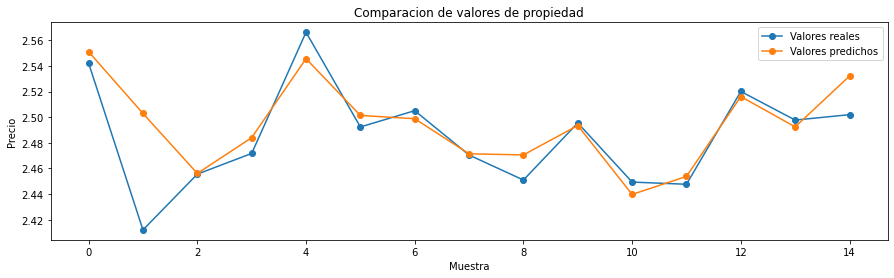

In [ ]:
get_random_sample(vote_mod, 15)

##StackingRegressor

De igual manera, empleo , del total de los modelos anteriores, solo los que obtuvieron un score mas alto. Definiendo el nombre del modelo, para realizar un ensamble en un único modelo. Estableciendo como meta estimador a `GradientBoostingRegressor`

In [ ]:
stregr = StackingRegressor(regressors=[ridge,tree_reg, clf, bay_reg], 
                           meta_regressor=vote_mod,
                           use_features_in_secondary=True
                          )

In [ ]:
evaluar_modelo(stregr, X_train, X_test, y_train, y_test) 

* R2 del modelo  en train: 0.9796112743743611
RMSE en train: 0.007919811974434355
* R2 del modelo en test: 0.857631607210571
RMSE en test: 0.02077892160625739


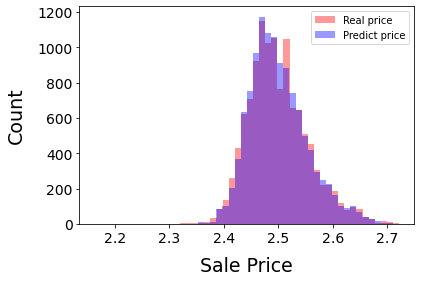

In [ ]:
graficos_prediccion(stregr)

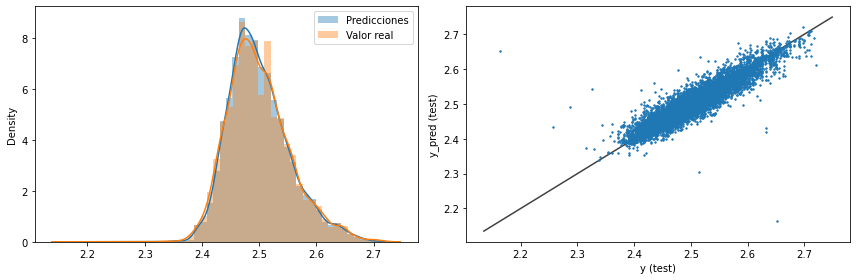

In [ ]:
graficos(stregr, X_test, y_test)

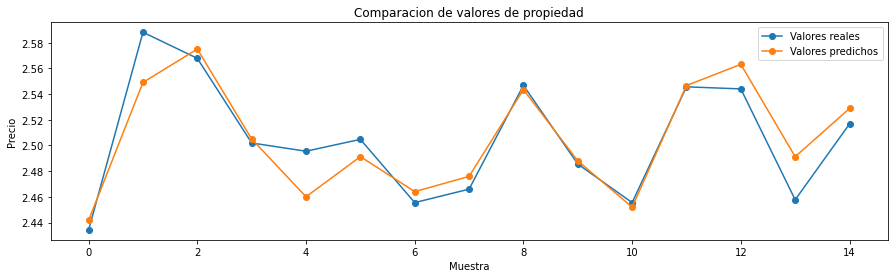

In [ ]:
get_random_sample(stregr, 15)

https://github.com/Shreyas3108/house-price-prediction/blob/master/housesales.ipynb

# Red neuronal

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network

##MLPRegressor

Esta red neuronal, funciona similar a un modelo de Machine Learning, ya que su estructura se encuentra definida, presentando hyper parámetros por default,  que pueden ser modificados en busca de una mejor optimización.

In [ ]:
#Defino el modelo
mlpr = MLPRegressor(
    solver='adam',
    alpha=1e-5,
    hidden_layer_sizes=(8,3),
    random_state=40)

In [ ]:
mlpr.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(8, 3), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=40, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
evaluar_modelo(mlpr, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.8237733551169909
RMSE en train: 0.023283894174600566
* R2 del modelo en test: 0.8237529458513944
RMSE en test: 0.023119431294815147


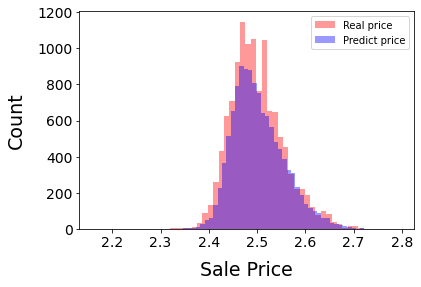

In [ ]:
graficos_prediccion(mlpr)

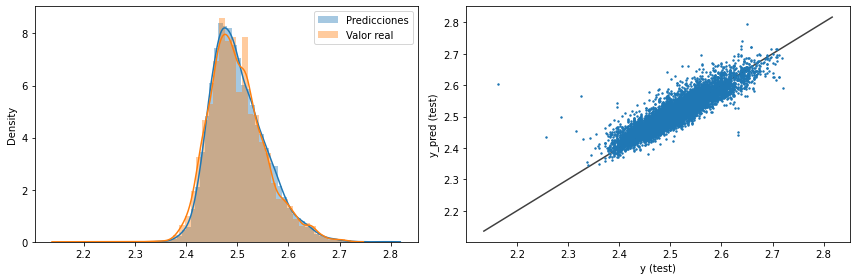

In [ ]:
graficos(mlpr, X_test, y_test)

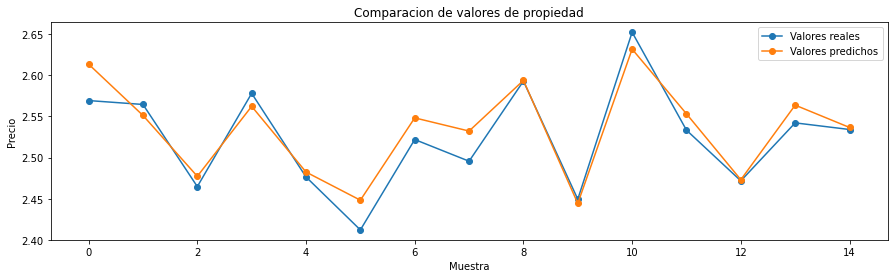

In [ ]:
get_random_sample(mlpr, 15)

##Keras-Sequential

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_3_keras_l1_l2.ipynb

In [ ]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False


Note: using Google CoLab


In [ ]:
#Convierto los datos de entrenamiento y test a formato compatible con la red neuronal
x_train1= X_train.values.tolist()
y_train1 = y_train.values.tolist()
x_test1 = X_test.values.tolist()
y_test1 = y_test.values.tolist()

In [ ]:
#Defino la red
model = Sequential()
model.add(Dense(10, input_dim=72, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

#Entrenamiento
model.fit(x_train1, y_train1,verbose=2,epochs=100)

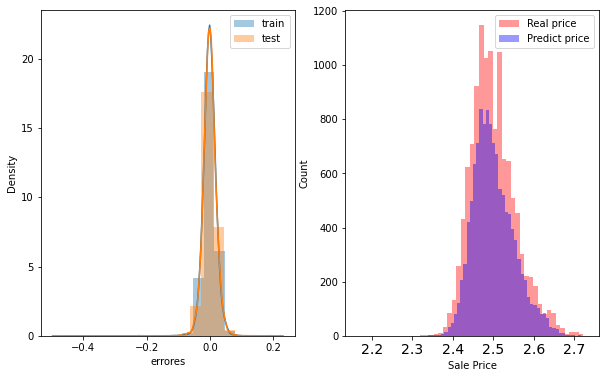

In [ ]:
graficos_error(model)

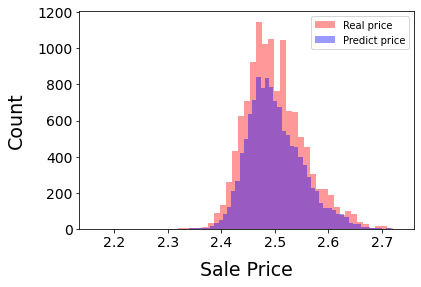

In [ ]:
graficos_prediccion(model)

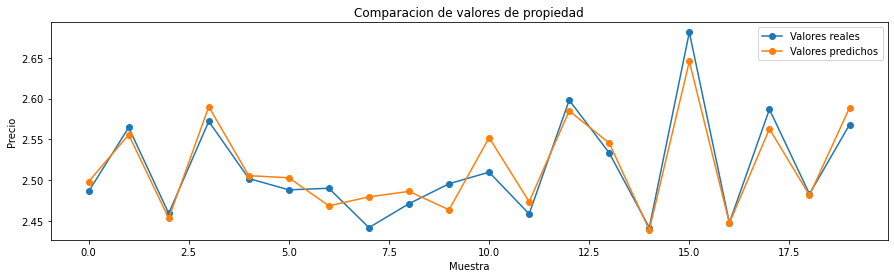

In [ ]:
get_random_sample(model, 20)

In [ ]:
pred = model.predict(x_test1)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test1))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.020822263776949696


## KerasRegressor

##Keras

https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [ ]:
pip install Keras

In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.0


In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4672      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = X_train[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.01592389],
       [ 0.15945604],
       [ 0.18633921],
       [ 0.12339719],
       [ 0.04706358],
       [-0.00436921],
       [-0.03465565],
       [ 0.1115123 ],
       [ 0.06944402],
       [ 0.27552816]], dtype=float32)

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [ ]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

374/374 - 0s - loss: 0.0679 - mae: 0.1911 - mse: 0.0679
Testing set Mean Abs Error:  0.19 MPG


Obtener importancia de caracteristicas
https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

-> optimizacion bayesiana

-> open street maps api (Para obtener cosas de plusvalia segun cordenadas)

-> Probar super Vector Regresor

-> Probar extra modelo 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

-> Keras Regresor
https://www.kaggle.com/hendraherviawan/regression-with-kerasregressor
https://stackoverflow.com/questions/44132652/keras-how-to-perform-a-prediction-using-kerasregressor
https://www.heatonresearch.com/2017/07/22/keras-getting-started.html
https://github.com/jeffheaton/t81_558_deep_learning

-> Staking
https://www.kaggle.com/amiiiney/price-prediction-regularization-gbms

->limpieza de Outliers
https://www.aprendemachinelearning.com/deteccion-de-outliers-en-python-anomalia/

->Metrica para evaluar subestimacion

In [ ]:
Guardar Modelo #import module import pickle
#Train the data model.fit(X_train, X_test)
#Dump the model with open('fitted_model.pickle','wb') as modelFile: pickle.dump(model,modelFile) 

Leer modelo 
#import module import pickle
#Load the model - No need to TRAIN it again(6 hours saved) with open('fitted_model.pickle','rb') as modelFile:
 #model = pickle.load(modelFile) 
#Predict with the test set prediction = model.predict(X_test) 